In [1]:
import yaml
import json
import os

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow_addons.metrics import MatthewsCorrelationCoefficient
import matplotlib.pyplot as plt
from seaborn import heatmap
from tqdm import tqdm
import pandas as pd
import numpy as np

from utils.train.visualization import analyze_history
from utils.train.classifier import load_model
from utils.models import resnet_cifar, resnet
from utils.datasets import get_generators
from utils.misc import log_config
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score
from config.datasets_config import DATASETS_CONFIG

In [2]:
def load_datagens():
    datagens = []

    datagens.append(get_generators(
        splits=['test'],
        image_shape=config['image_shape'],
        batch_size=config['batch_size'],
        random_seed=config['random_seed'],
        dataset_config=dataset_config,
        separate_evaluation_groups=False
    )[0])
    datagens.extend(get_generators(
        splits=['test'],
        image_shape=config['image_shape'],
        batch_size=config['batch_size'],
        random_seed=config['random_seed'],
        dataset_config=dataset_config,
        separate_evaluation_groups=True
    )[0])

    return datagens, list(datagens[0].class_indices.keys())

In [3]:
def load_classifier():
    model = load_model(config_dict=config, evaluation=True)
    model.load_weights(os.path.join(save_dir, 'classifier.h5'))

    return model

In [4]:
def create_conf_matrix(datagen, model, classes):
    print('\nGenerating confusion matrix...')
    all_labels = []
    all_preds = []

    for _ in tqdm(range(len(datagen)), ncols=120):
        x, labels = next(datagen)
        preds = model.predict(x)
        all_labels.extend(labels)
        all_preds.extend(preds)

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    conf_matrix = confusion_matrix(np.argmax(all_labels, axis=-1), np.argmax(all_preds, axis=-1), normalize='true')
    conf_matrix = pd.DataFrame(conf_matrix, columns=classes, index=classes)

    plt.figure(figsize=(10, 8))
    heatmap(conf_matrix, annot=True)
    plt.ylabel('True Classes')
    plt.xlabel('Predicted Classes')
    plt.savefig(os.path.join(visualization_save_dir, 'confusion_matrix.png'))

    # Calculate AUROC
    for average in ['micro', 'macro', 'weighted']:
        score = roc_auc_score(all_labels, all_preds, average=average)
        print(average.title(), 'AUROC:', round(score, 4))

In [17]:
save_dir = 'trained_models/classifiers/frac_data/supervised_0.01'
print('Evaluating model from:', save_dir)

# Load config file
if 'config.pickle' in os.listdir(save_dir):
    import pickle
    with open(os.path.join(save_dir, 'config.pickle'), 'rb') as f:
        config = pickle.load(f)
    with open(os.path.join(save_dir, 'config.yaml'), 'w') as f:
        yaml.dump(config, f)

with open(os.path.join(save_dir, 'config.yaml')) as file:
    config = yaml.safe_load(file)
dataset_config = DATASETS_CONFIG[config['dataset_type']]
log_config(config)

# Set random seed
np.random.seed(config['random_seed'])
tf.random.set_seed(config['random_seed'])

# Where the generated plots should be saved
visualization_save_dir = os.path.join(save_dir, 'evaluation_graphs')

Evaluating model from: trained_models/classifiers/frac_data/supervised_0.01
batch_size                                         256
class_weight                                       None
classes                                            ['fat', 'necrotic_debris', 'plasma_cell_infiltrate', 'stroma', 'tils', 'tumor']
dataset_type                                       tissue_6_0.3
encoder_lr                                         0.005
encoder_trainable                                  True
encoder_weights_path                               None
epochs                                             30
gpu_used                                           ['GPU:0', 'GPU:1', 'GPU:2', 'GPU:3']
head_lr                                            0.005
image_shape                                        [224, 224, 3]
latent_dim                                         64
lr_scheduler                                       plateau
model_name                                         supervised_0.01
model

At the early stop epochs: {'loss': 2.72858, 'acc': 0.3623, 'top_2_accuracy': 0.63281, 'MCC': 0.1019, 'auc': 0.58388, 'val_loss': 34820046454784.0, 'val_acc': 0.33718, 'val_top_2_accuracy': 1.0, 'val_MCC': 0.0, 'val_auc': 0.5, 'lr': 0.005}
Found 20661 validated image filenames belonging to 6 classes.
minor: ['fat' 'necrotic_debris' 'plasma_cell_infiltrate' 'tils'] Found 4554 validated image filenames belonging to 6 classes.
major: ['stroma' 'tumor'] Found 16107 validated image filenames belonging to 6 classes.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 224, 224, 3)]     0        

  0%|                                                                                            | 0/81 [00:00<?, ?it/s]


Generating confusion matrix...


100%|███████████████████████████████████████████████████████████████████████████████████| 81/81 [01:32<00:00,  1.14s/it]


Micro AUROC: 0.406
Macro AUROC: 0.5002
Weighted AUROC: 0.5


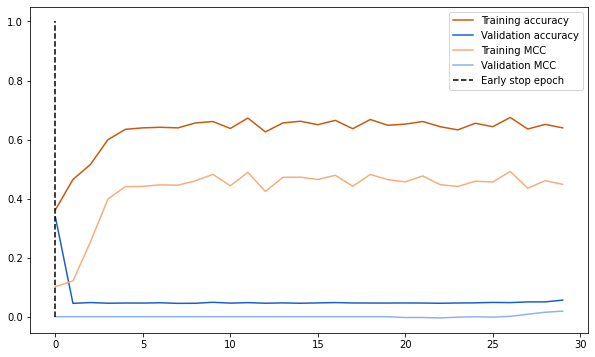

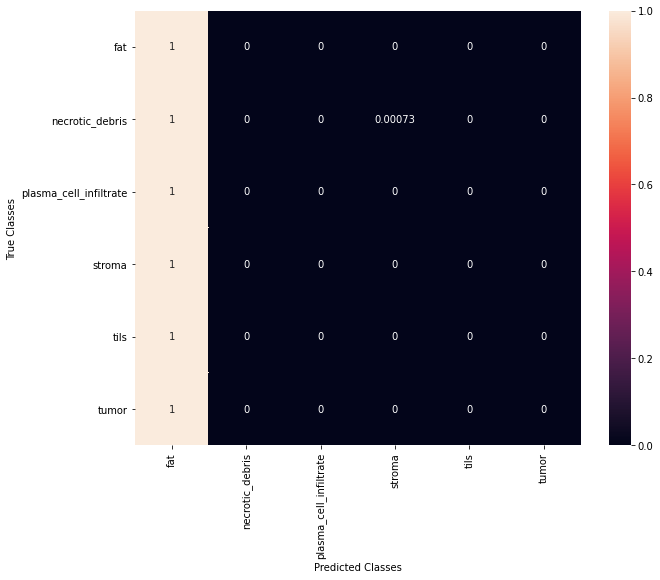

In [18]:
# Create training curves, early stop values, etc.
os.makedirs(visualization_save_dir, exist_ok=True)

# Collect early stopping statistics and generate training curves
es_stats = analyze_history(
    os.path.join(save_dir, 'history.pickle'),
    save_visualization=True,
    return_es_stats=True,
    root_save_dir=visualization_save_dir
)
print('At the early stop epochs:', es_stats)

# Evaluate classifier on test set
dataset_config['train_split'] = config['train_split']
dataset_config['validation_split'] = config['validation_split']
datagens, classes = load_datagens()

num_classes = len(classes)
config['num_classes'] = num_classes
config['steps_per_epoch'] = 1  # Used to set up optimizer

model = load_classifier()

for n, datagen in zip(['all', 'minor', 'major'], datagens):
    print(n + ':')
    model.evaluate(datagen)

# Create confusion matrix and calculate AUROC scores
create_conf_matrix(
    datagen=datagens[0],
    model=model,
    classes=classes
)

Evaluating model from: trained_models/classifiers/frac_data/barlow_0.05
batch_size                                         256
class_weight                                       None
classes                                            ['fat', 'necrotic_debris', 'plasma_cell_infiltrate', 'stroma', 'tils', 'tumor']
dataset_type                                       tissue_6_0.3
encoder_lr                                         0.03
encoder_trainable                                  True
encoder_weights_path                               trained_models/encoders/lamb_100_4096/resnet.h5
epochs                                             30
gpu_used                                           ['GPU:0', 'GPU:1', 'GPU:2', 'GPU:3']
head_lr                                            0.03
image_shape                                        [224, 224, 3]
latent_dim                                         64
lr_scheduler                                       cosine
model_name                          

  0%|                                                                                            | 0/81 [00:00<?, ?it/s]


Generating confusion matrix...


100%|███████████████████████████████████████████████████████████████████████████████████| 81/81 [01:33<00:00,  1.16s/it]


Micro AUROC: 0.956
Macro AUROC: 0.9252
Weighted AUROC: 0.9242
Evaluating model from: trained_models/classifiers/frac_data/supervised_0.05
batch_size                                         256
class_weight                                       None
classes                                            ['fat', 'necrotic_debris', 'plasma_cell_infiltrate', 'stroma', 'tils', 'tumor']
dataset_type                                       tissue_6_0.3
encoder_lr                                         0.005
encoder_trainable                                  True
encoder_weights_path                               None
epochs                                             30
gpu_used                                           ['GPU:0', 'GPU:1', 'GPU:2', 'GPU:3']
head_lr                                            0.005
image_shape                                        [224, 224, 3]
latent_dim                                         64
lr_scheduler                                       plateau
model_name

  0%|                                                                                            | 0/81 [00:00<?, ?it/s]


Generating confusion matrix...


100%|███████████████████████████████████████████████████████████████████████████████████| 81/81 [01:34<00:00,  1.16s/it]


Micro AUROC: 0.9469
Macro AUROC: 0.8967
Weighted AUROC: 0.9059


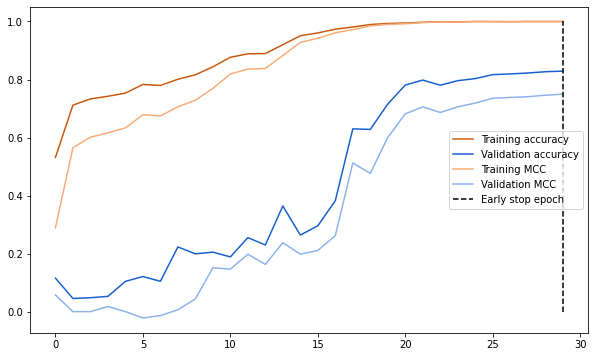

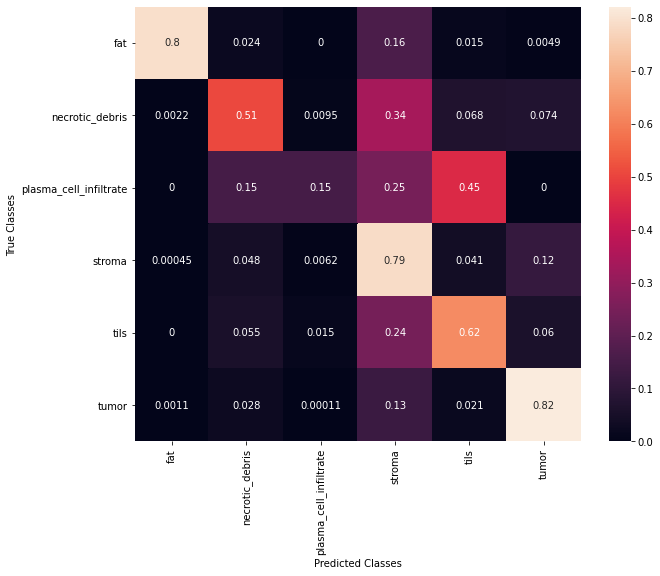

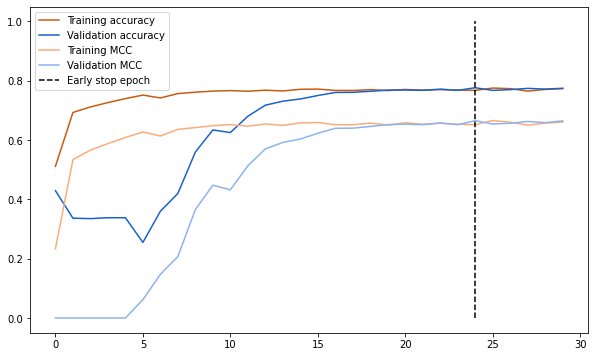

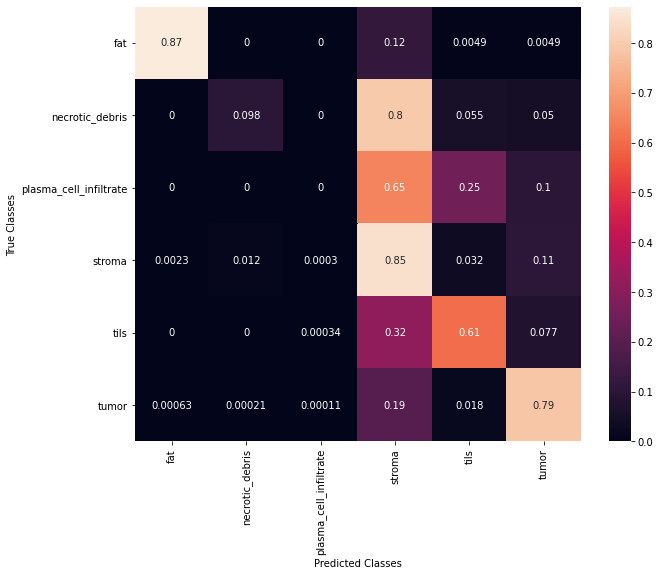

In [19]:
for name in ['barlow_0.05', 'supervised_0.05']:
    save_dir = f'trained_models/classifiers/frac_data/{name}'
    print('Evaluating model from:', save_dir)

    # Load config file
    if 'config.pickle' in os.listdir(save_dir):
        import pickle
        with open(os.path.join(save_dir, 'config.pickle'), 'rb') as f:
            config = pickle.load(f)
        with open(os.path.join(save_dir, 'config.yaml'), 'w') as f:
            yaml.dump(config, f)

    with open(os.path.join(save_dir, 'config.yaml')) as file:
        config = yaml.safe_load(file)
    dataset_config = DATASETS_CONFIG[config['dataset_type']]
    log_config(config)

    # Set random seed
    np.random.seed(config['random_seed'])
    tf.random.set_seed(config['random_seed'])

    # Where the generated plots should be saved
    visualization_save_dir = os.path.join(save_dir, 'evaluation_graphs')
    
    # Create training curves, early stop values, etc.
    os.makedirs(visualization_save_dir, exist_ok=True)

    # Collect early stopping statistics and generate training curves
    es_stats = analyze_history(
        os.path.join(save_dir, 'history.pickle'),
        save_visualization=True,
        return_es_stats=True,
        root_save_dir=visualization_save_dir
    )
    print('At the early stop epochs:', es_stats)

    # Evaluate classifier on test set
    dataset_config['train_split'] = config['train_split']
    dataset_config['validation_split'] = config['validation_split']
    datagens, classes = load_datagens()

    num_classes = len(classes)
    config['num_classes'] = num_classes
    config['steps_per_epoch'] = 1  # Used to set up optimizer

    model = load_classifier()

    for n, datagen in zip(['all', 'minor', 'major'], datagens):
        print(n + ':')
        model.evaluate(datagen)

    # Create confusion matrix and calculate AUROC scores
    create_conf_matrix(
        datagen=datagens[0],
        model=model,
        classes=classes
    )